## Imports

In [4]:
import googlemaps
import pandas as pd
import numpy as np
import re
import os
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from pyproj import CRS
import math

## Imports

In [5]:
pd.set_option('display.max_columns',None)

## Links

Miami-Dade data download: https://gis-mdc.opendata.arcgis.com/datasets/MDC::property-boundary-view/about
DOR Use code descriptions: https://gis-mdc.opendata.arcgis.com/datasets/MDC::dor-code/explore

Palm Beach data download: https://opendata2-pbcgov.opendata.arcgis.com/datasets/PBCGOV::property-information-table/explore

Broward Property Appraiser "Contact Us" page: https://bcpa.net/phone.asp

## Data read-in

In [6]:
# Read in geographic data
MiamiDade_geo = gpd.read_file('miamidade_2022pin')
PalmBeach_geo = gpd.read_file('palmbeach_2022pin')
Broward_geo = gpd.read_file('broward_2022pin')

In [21]:
So_Fla_geo_list = [MiamiDade_geo,PalmBeach_geo,Broward_geo]

In [22]:
So_Fla_geo = gpd.GeoDataFrame(pd.concat(So_Fla_geo_list,ignore_index=True))

In [24]:
# Set the desired CRS
target_crs = CRS.from_epsg(4326)

# Change it to the desired crs
So_Fla = So_Fla_geo.to_crs(target_crs)
# MiamiDade = MiamiDade_geo.to_crs(target_crs)
# PalmBeach = PalmBeach_geo.to_crs(target_crs)
# Broward = Broward_geo.to_crs(target_crs)

In [12]:
# Load in Property Appraiser data
MiamiDade_data = gpd.read_file('NAL23F202201.dbf')
PalmBeach_data = gpd.read_file('NAL60F202201.dbf')
Broward_data = gpd.read_file('NAL16F202201.dbf')

In [ ]:
# Concat non geo dataframes
data_list = [MiamiDade_data,PalmBeach_data,Broward_data]

So_Fla_data = gpd.GeoDataFrame(pd.concat(data_list,ignore_index=True))

In [ ]:
# Drop the empty 'geometry' column
So_Fla_data = So_Fla_data.drop(columns='geometry')

In [27]:
# Convert the 'DOR_UC' code to type int
So_Fla_data['DOR_UC'] = So_Fla_data['DOR_UC'].astype(int)

In [30]:
# Whittle down the data to agricutlrual properties only
So_Fla_data_agri = So_Fla_data[(So_Fla_data['DOR_UC'] >= 50) & (So_Fla_data['DOR_UC'] <= 69)]

In [32]:
merged_So_Fla_agri = pd.merge(So_Fla_data_agri,So_Fla, left_on='PARCEL_ID', right_on='PARCELNO', how='inner')

In [35]:
columns_to_keep = ['PARCEL_ID','DOR_UC','PHY_ADDR1','PHY_CITY','geometry']

In [36]:
merged_So_Fla_agri_final = merged_So_Fla_agri[columns_to_keep]

In [37]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_So_Fla_agri_final, geometry='geometry')

# Save the GeoDataFrame as a GeoJSON file
gdf.to_file('SoFla_agri.geojson', driver='GeoJSON')

## SoFla Other Restricted Properties

In [59]:
from shapely.ops import cascaded_union
from shapely.geometry import Polygon

In [122]:
keep_list = ['47', '91', '96', '49', '91', '20']
So_Fla_geo_restricted = So_Fla_geo[So_Fla_geo['PA_UC'].isin(keep_list)]

In [123]:
merged_So_Fla_restricted = pd.merge(So_Fla_geo_restricted,So_Fla, left_on='PARCEL_ID', right_on='PARCELNO', how='inner')

In [124]:
merged_So_Fla_restricted_export = merged_So_Fla_restricted

In [129]:
# Create a GeoDataFrame from the DataFrame
merged_So_Fla_restricted_export = gpd.GeoDataFrame(merged_So_Fla_restricted_export, geometry='geometry')

# Now you have a GeoDataFrame that you can export as GeoJSON
merged_So_Fla_restricted_export.to_file('restricted_export.geojson', driver='GeoJSON')

## Create buffer

In [106]:
buffer_target_CRS = CRS.from_epsg(32634)

In [107]:
# Change it to the desired crs
merged_So_Fla_restricted_export = merged_So_Fla_restricted_export.to_crs(buffer_target_CRS)

In [108]:
merged_So_Fla_restricted_export['extended_geometry'] = merged_So_Fla_restricted_export.geometry.buffer(16093.4)  # 10 miles in meters

In [109]:
merged_So_Fla_restricted_export = merged_So_Fla_restricted_export.drop(columns='geometry')
merged_So_Fla_restricted_export = merged_So_Fla_restricted_export.rename(columns={'extended_geometry':'geometry'})

In [110]:
merged_So_Fla_restricted_export = merged_So_Fla_restricted_export.to_crs(target_crs)

In [116]:
final_buffer = merged_So_Fla_restricted_export[['CO_NO','geometry']]

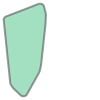

In [118]:
from shapely.geometry import MultiPolygon

# Assuming you have a GeoDataFrame called gdf with a 'geometry' column containing polygons

# Create a single polygon representing the outermost border
outer_polygon = final_buffer['geometry'].unary_union

# Check if the result is a MultiPolygon and convert it to a Polygon if necessary
if isinstance(outer_polygon, MultiPolygon):
    outer_polygon = outer_polygon.convex_hull

# Now you have a single polygon representing the outermost border
outer_polygon

In [119]:
# Create a new GeoDataFrame with the outer polygon
outer_gdf = gpd.GeoDataFrame(geometry=[outer_polygon])

# Set the coordinate reference system (CRS) if needed
# outer_gdf.crs = ...

# Export the GeoDataFrame to a GeoJSON file
outer_gdf.to_file('outer_polygon.geojson', driver='GeoJSON')